In [1]:
import numpy as np 
import pandas as pd
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
import datetime #utile pour l'export des graphiques automatiquement 

In [2]:
#Retrait des limites d'affichage
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [3]:
openfoodfacts = pd.read_csv("openfoodfacts.csv", sep='\t', low_memory=False)

<u>Objectif de la mission confiée à l'entreprise</u> :
<i>"créer un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données"</i>

# Nettoyer et filtrer les features et produits

In [6]:
openfoodfacts.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
openfoodfacts.shape

(320772, 162)

## Liste des features du fichier, quantitatives (numériques) ou qualitatives (catégorielles).

In [9]:
#Retrait des limites d'affichage
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#openfoodfacts.dtypes

In [10]:
openfoodfacts['quantity'].nunique

<bound method IndexOpsMixin.nunique of 0          1kg
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
320767       1
320768     NaN
320769    50 g
320770     67g
320771     NaN
Name: quantity, Length: 320772, dtype: object>

In [11]:
# Valeurs manquantes en points
openfoodfacts.isnull().sum()

code                           23
url                            23
creator                         2
created_t                       3
created_datetime                9
                            ...  
carbon-footprint_100g      320504
nutrition-score-fr_100g     99562
nutrition-score-uk_100g     99562
glycemic-index_100g        320772
water-hardness_100g        320772
Length: 162, dtype: int64

In [12]:
#Retrait des limites d'affichage
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
openfoodfacts.dtypes
# Valeurs manquantes en %
((openfoodfacts.isnull().sum() / len(openfoodfacts)) * 100).sort_values(ascending=False)

water-hardness_100g                      100.000000
no_nutriments                            100.000000
ingredients_that_may_be_from_palm_oil    100.000000
nutrition_grade_uk                       100.000000
nervonic-acid_100g                       100.000000
                                            ...    
created_datetime                           0.002806
created_t                                  0.000935
creator                                    0.000623
last_modified_datetime                     0.000000
last_modified_t                            0.000000
Length: 162, dtype: float64

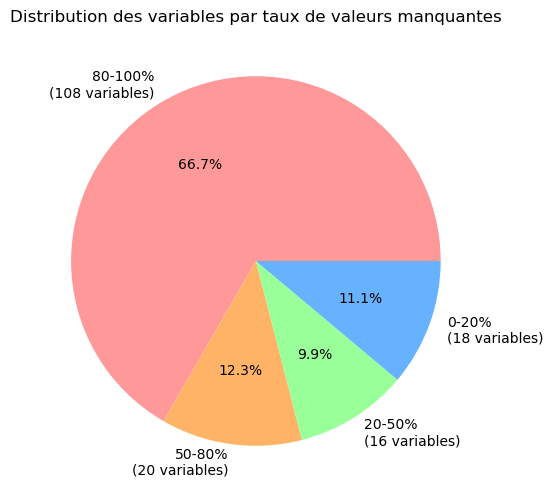

In [13]:
def donnees_manquantes(df):
    missing_percentages = (df.isnull().sum() / len(df) * 100)
    
    # Ccatégories
    categories = {
        '80-100%': sum(missing_percentages >= 80),
        '50-80%': sum((missing_percentages >= 50) & (missing_percentages < 80)),
        '20-50%': sum((missing_percentages >= 20) & (missing_percentages < 50)),
        '0-20%': sum(missing_percentages < 20)
    }
    
    # Visualisation en pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(categories.values(),
            labels=[f"{k}\n({v} variables)" for k, v in categories.items()],
            autopct='%1.1f%%',
            colors=['#FF9999', '#FFB366', '#99FF99', '#66B2FF'])
    
    plt.title('Distribution des variables par taux de valeurs manquantes')
    plt.show()
    
donnees_manquantes(openfoodfacts)



In [14]:
# Valeurs presentes en %
#(100-(openfoodfacts.isnull().sum() / len(openfoodfacts)) * 100).sort_values(ascending=False)

## Choix de la cible pnns_groups_1

In [16]:
openfoodfacts.pnns_groups_1.info()

<class 'pandas.core.series.Series'>
RangeIndex: 320772 entries, 0 to 320771
Series name: pnns_groups_1
Non-Null Count  Dtype 
--------------  ----- 
91513 non-null  object
dtypes: object(1)
memory usage: 2.4+ MB


In [17]:
openfoodfacts['pnns_groups_1'].describe()

count       91513
unique         14
top       unknown
freq        22624
Name: pnns_groups_1, dtype: object

### Controle des libellés des pnns_groups_1

In [19]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


In [20]:
# Extraire les pnns_groups_1 uniques
pnns_groups_1_unique = openfoodfacts['pnns_groups_1'].unique()

# Crée un DataFrame à partir des pnns_groups_1 uniques
pnns_groups_1_counts = pd.DataFrame(pnns_groups_1_unique, columns=['pnns_groups_1'])

# Trie les pnns_groups_1 par ordre alphabétique 
pnns_groups_1_counts = pnns_groups_1_counts.sort_values('pnns_groups_1').reset_index(drop=True)

# Exporte en CSV
pnns_groups_1_counts.to_csv('pnns_groups_1_counts.csv', index=False, encoding='utf-8-sig')

## Suppression des lignes (produits) sans valeur cible (pnns_groups_1)

In [22]:
len(openfoodfacts) #Nombre de lignes avant suppression

320772

In [23]:
df_pnns_groups_1 = openfoodfacts.dropna(subset=['pnns_groups_1']) #supprime les lignes (ie les produits) pnns_groups_1 n'est pas indiqué

In [24]:
len(df_pnns_groups_1) #Nombre de lignes après suppression ou pnns_groups_1 n'est pas indiqué

91513

In [25]:
df_pnns_groups_1 = df_pnns_groups_1[~df_pnns_groups_1['pnns_groups_1'].isin(['unknown'])] #supprime les lignes (ie les produits) pnns_groups_1 est indiqué inconnu

In [26]:
len(df_pnns_groups_1) #Nombre de lignes après suppression ou pnns_groups_1 est indiqué inconnu

68889

## Suppression des lignes ou les produits sont non vendus en France

In [28]:
pays_liste = df_pnns_groups_1['countries_fr'].unique().tolist()
pays_liste

['Canada',
 'Royaume-Uni',
 'France',
 'Allemagne',
 'Espagne',
 'États-Unis',
 'France,Royaume-Uni',
 'Belgique,France,Pays-Bas,Royaume-Uni',
 'Suisse',
 'Canada,France,Suisse,États-Unis',
 'France,États-Unis',
 'Belgique,France',
 'Arabie saoudite',
 nan,
 'Australie,États-Unis',
 'Australie',
 'France,Suisse',
 'États-Unis,en:Pays-bas',
 'Espagne,Royaume-Uni,en:Scotland',
 'Mexique',
 'Allemagne,États-Unis',
 'États-Unis,en:Deutschland',
 'France,Suisse,États-Unis',
 'Suisse,États-Unis',
 'Danemark,États-Unis,en:Spanien',
 'Pays-Bas',
 'Belgique,Suisse',
 'France,Allemagne',
 'Serbie',
 'France,Italie',
 'La Réunion',
 'Cuba',
 'Canada,États-Unis',
 'Espagne,États-Unis',
 'Australie,France,Royaume-Uni',
 'France,Royaume-Uni,États-Unis',
 'Autriche',
 'Chine,Suisse',
 'Saint-Pierre-et-Miquelon',
 'Canada,France',
 'Quebec',
 'Canada,Quebec',
 'Canada,France,Suisse',
 'Belgique,Canada,France,Suisse',
 'France,Saint-Pierre-et-Miquelon',
 'Canada,Portugal',
 'Allemagne,Suisse',
 'France

In [29]:
# Filtre les lignes où 'France' apparaît
df_pnns_groups_1 = df_pnns_groups_1[df_pnns_groups_1['countries_fr'].str.contains('France', na=False)]

In [30]:
len(df_pnns_groups_1) #Nombre de lignes après suppression

52383

## Séparation de la cible du reste du dataset

In [32]:
df_pnns_groups_1.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
182,0000005200016,http://world-fr.openfoodfacts.org/produit/0000...,sigoise,1441186657,2015-09-02T09:37:37Z,1442570752,2015-09-18T10:05:52Z,lentilles vertes,NaN,1 kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,0000007730009,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1462806432,2016-05-09T15:07:12Z,1482359150,2016-12-21T22:25:50Z,Biscuits sablés fourrage au cacao,Biscuits sablés déclassés fourrage au cacao,1 kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,0000009336247,http://world-fr.openfoodfacts.org/produit/0000...,tacite,1479029877,2016-11-13T09:37:57Z,1479030010,2016-11-13T09:40:10Z,NaN,Bonbons acidulés Raisin Fraise,"46,7 g",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,0000010090206,http://world-fr.openfoodfacts.org/produit/0000...,sebleouf,1370977431,2013-06-11T19:03:51Z,1445083431,2015-10-17T12:03:51Z,Thé de Noël aromatisé orange-cannelle,NaN,75 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,0000040608754,http://world-fr.openfoodfacts.org/produit/0000...,andre,1345024108,2012-08-15T09:48:28Z,1439141731,2015-08-09T17:35:31Z,"Pepsi, Nouveau goût !",Boisson gazeuse rafraîchissante aux extraits n...,15 cl,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,2.0,NaN,NaN


In [33]:
df_pnns_groups_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52383 entries, 182 to 320765
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 65.1+ MB


In [34]:
df_pnns_groups_1.shape

(52383, 162)

In [35]:
df_pnns_groups_1.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,44527.000000,44527.000000,0.0,44527.000000,0.0,0.0,42480.000000,25.000000,40315.000000,...,40.000000,2178.000000,164.000000,666.000000,0.0,164.000000,40007.000000,40007.000000,0.0,0.0
mean,NaN,1.927550,0.068228,NaN,0.154895,NaN,NaN,1090.691967,460.566000,13.455152,...,6.559910,39.213967,15.414634,49.263213,NaN,376.364053,8.377834,7.895468,NaN,NaN
std,NaN,2.602955,0.255942,NaN,0.465219,NaN,NaN,798.938712,542.634088,17.375813,...,1.672411,30.583026,3.764383,19.228087,NaN,414.290965,9.084101,9.572927,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,393.000000,49.400000,1.200000,...,6.275000,10.000000,12.000000,32.000000,NaN,150.000000,1.000000,0.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,998.000000,167.000000,6.600000,...,7.000000,40.000000,15.000000,48.000000,NaN,219.500000,8.000000,6.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1635.000000,803.000000,21.700000,...,7.355000,60.000000,15.000000,65.000000,NaN,497.750000,15.000000,16.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,5.000000,NaN,NaN,18700.000000,1830.000000,380.000000,...,8.400000,100.000000,25.000000,100.000000,NaN,2520.000000,40.000000,35.000000,NaN,NaN


In [36]:
# Valeurs manquantes en points
df_pnns_groups_1.isnull().sum().sort_values(ascending=False)

water-hardness_100g          52383
allergens_fr                 52383
nucleotides_100g             52383
arachidonic-acid_100g        52383
ingredients_from_palm_oil    52383
                             ...  
states_tags                      0
states_fr                        0
main_category                    0
main_category_fr                 0
code                             0
Length: 162, dtype: int64

In [37]:
# Valeurs présentes en %
Taux_de_remplissage_pour_df_pnns_groups_1=(100-(df_pnns_groups_1.isnull().sum() / len(df_pnns_groups_1)) * 100).sort_values(ascending=False)
Taux_de_remplissage_pour_df_pnns_groups_1

code                   100.0
categories             100.0
pnns_groups_1          100.0
pnns_groups_2          100.0
states                 100.0
                       ...  
caproic-acid_100g        0.0
butyric-acid_100g        0.0
nucleotides_100g         0.0
stearic-acid_100g        0.0
water-hardness_100g      0.0
Length: 162, dtype: float64

<Axes: >

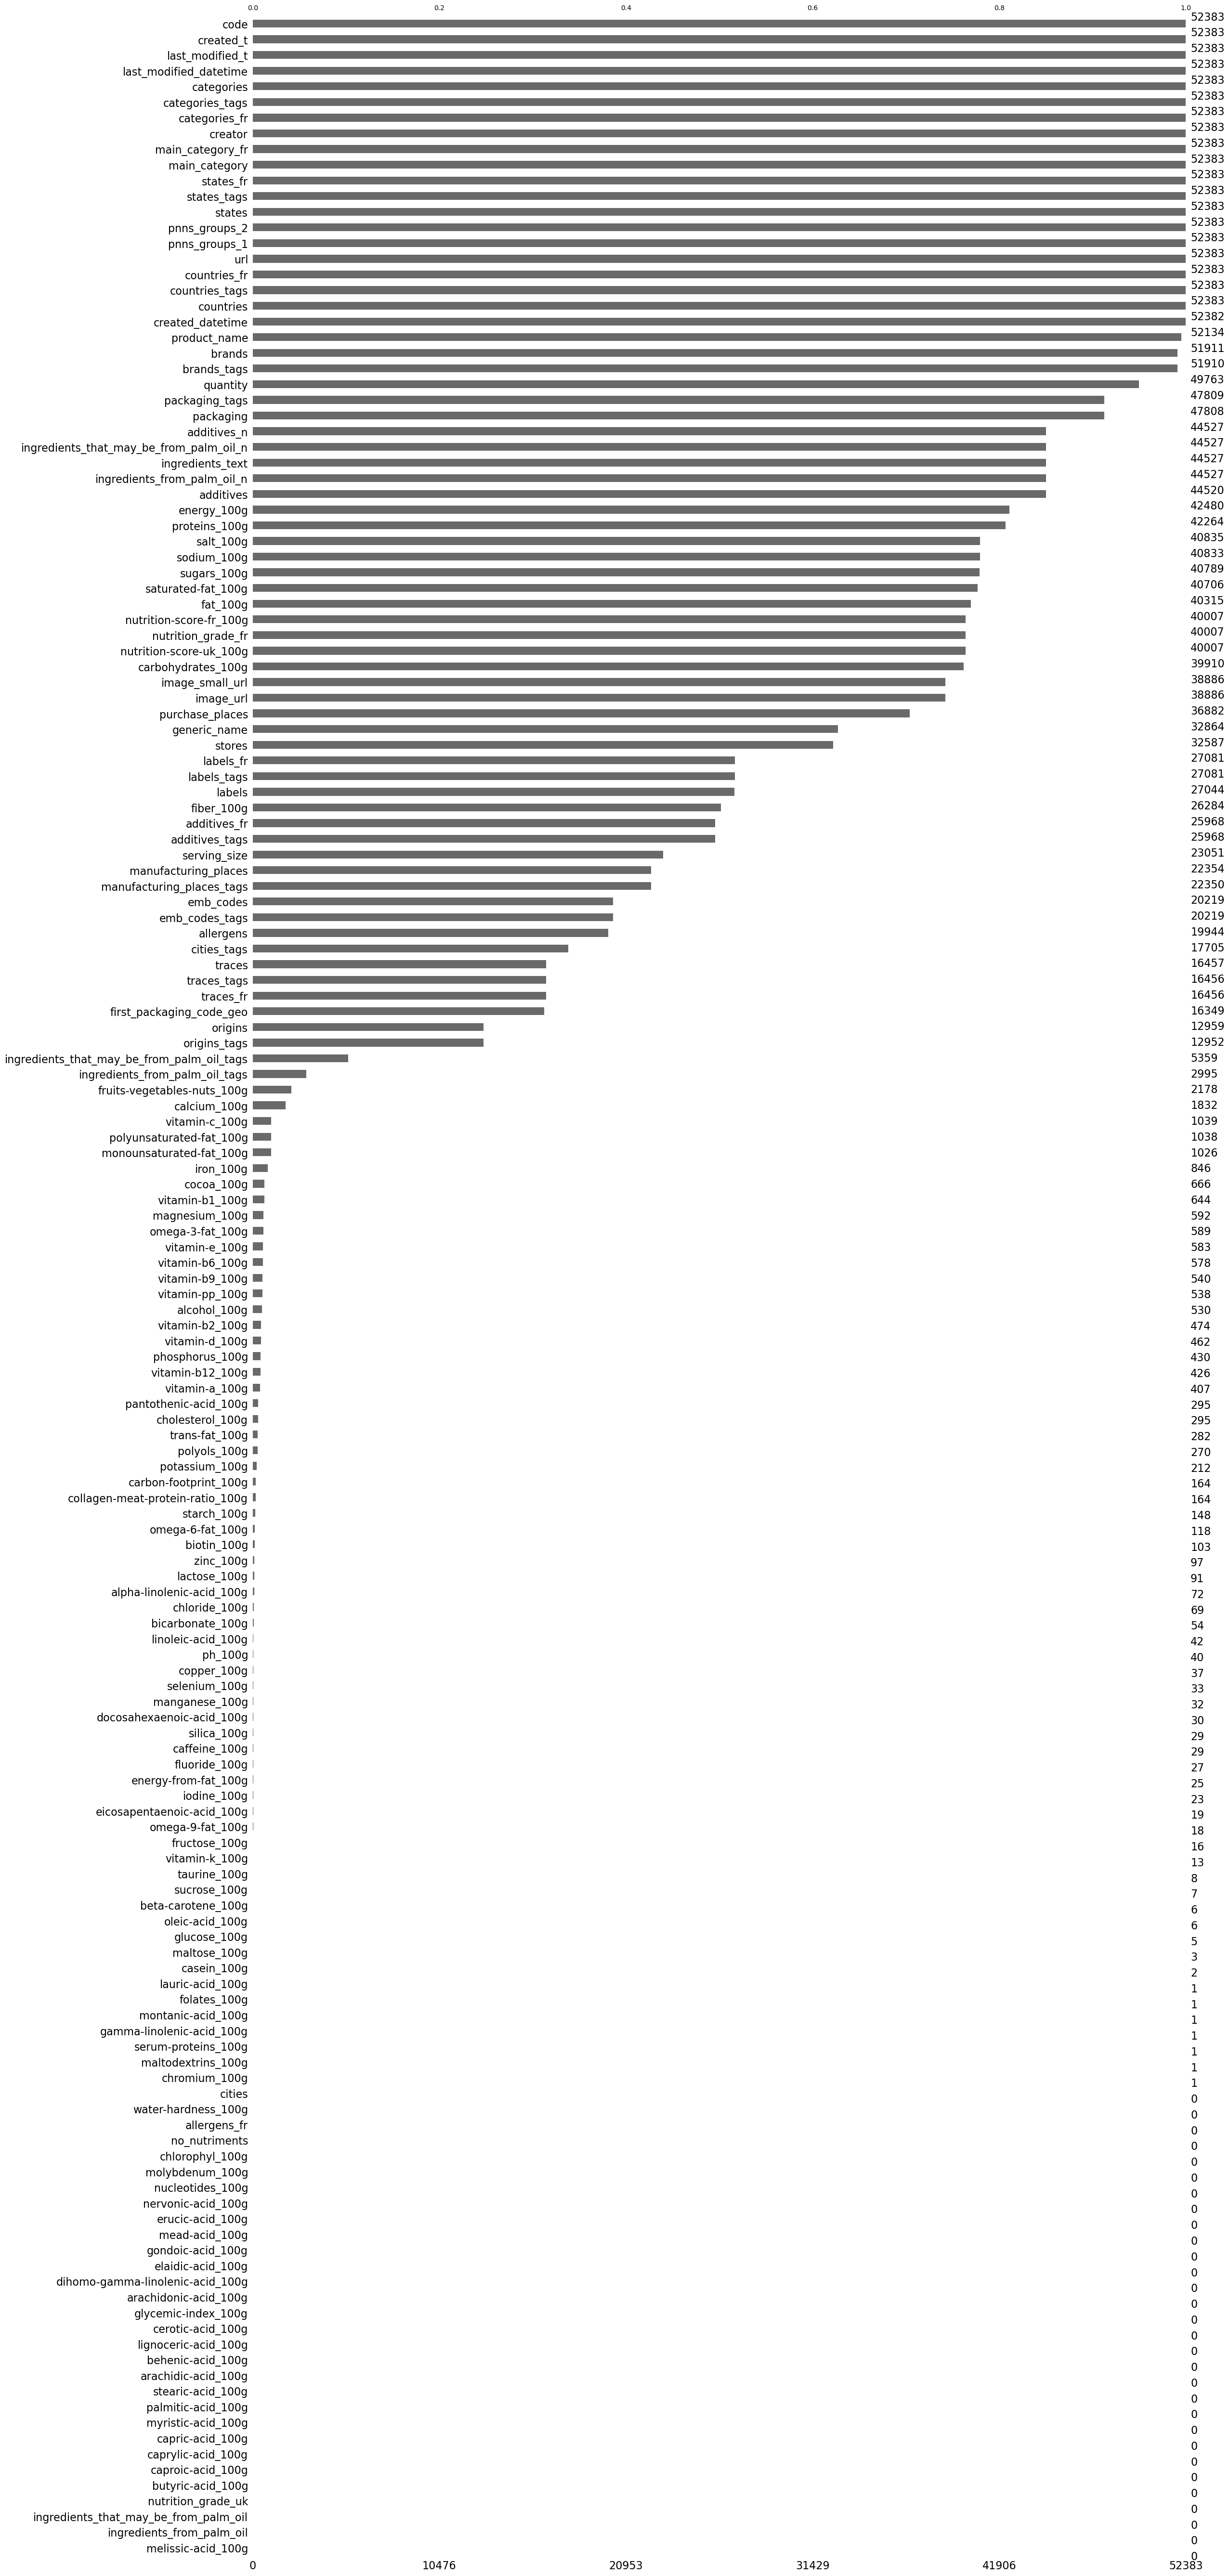

In [38]:
# Valeurs manquantes sous forme graphique (missingno)
# Calcul du % de valeurs non-nulles pour chaque colonne
null_counts = df_pnns_groups_1.isnull().sum()
non_null_counts = df_pnns_groups_1.shape[0] - null_counts
non_null_percentages = (non_null_counts / df_pnns_groups_1.shape[0]) * 100

# Tri des colonnes par pourcentage de valeurs non-nulles
sorted_columns = non_null_percentages.sort_values().index

# Créé le graphique avec les colonnes triées
msno.bar(df_pnns_groups_1[sorted_columns])

## Taux de remplissage des features du dataset

In [40]:
features_sup_50 = Taux_de_remplissage_pour_df_pnns_groups_1[Taux_de_remplissage_pour_df_pnns_groups_1 > 50] #valeurs presentes sup à 50%
features_sup_50

code                                       100.000000
categories                                 100.000000
pnns_groups_1                              100.000000
pnns_groups_2                              100.000000
states                                     100.000000
states_tags                                100.000000
states_fr                                  100.000000
main_category                              100.000000
main_category_fr                           100.000000
countries_fr                               100.000000
url                                        100.000000
categories_fr                              100.000000
countries                                  100.000000
categories_tags                            100.000000
last_modified_datetime                     100.000000
last_modified_t                            100.000000
created_t                                  100.000000
creator                                    100.000000
countries_tags              

In [41]:
variables_select = ['nutrition-score-fr_100g','energy_100g', 'carbohydrates_100g','proteins_100g','fat_100g',
                        'fiber_100g','sodium_100g','trans-fat_100g'
                       ]

### Coefficient de corrélation de Pearson

In [43]:
def correlation(df_pnns_groups_1, columns):
    """
    Calcule le coefficient de corrélation de Pearson pour toutes les paires de variables sélectionnées,
    après avoir supprimé les valeurs manquantes (NaN) et infinies (Inf).
    """
    # Nettoye les données : supprime les NaN et Inf
    df_pnns_groups_1_nettoye = df_pnns_groups_1[columns].replace([np.inf, -np.inf], np.nan).dropna()
    
    correlations = []
    
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            var1 = df_pnns_groups_1_nettoye[columns[i]]
            var2 = df_pnns_groups_1_nettoye[columns[j]]
            
            # Calcul du coefficient de corrélation de Pearson
            correlation, p_value = pearsonr(var1, var2)
            
            # Ajoute les résultats à la liste
            correlations.append({
                'Variable 1': columns[i],
                'Variable 2': columns[j],
                'Coefficient de corrélation': correlation.round(2),
                'p-value': p_value.round(2)
            })
    
    df_correlation = pd.DataFrame(correlations)
    return df_correlation

In [44]:
resultats_correlation = correlation(df_pnns_groups_1, variables_select)
resultats_correlation

,Variable 1,Variable 2,Coefficient de corrélation,p-value
0,nutrition-score-fr_100g,energy_100g,0.49,0.00
1,nutrition-score-fr_100g,carbohydrates_100g,0.25,0.00
2,nutrition-score-fr_100g,proteins_100g,-0.07,0.29
3,nutrition-score-fr_100g,fat_100g,0.32,0.00
4,nutrition-score-fr_100g,fiber_100g,0.02,0.71
5,nutrition-score-fr_100g,sodium_100g,0.22,0.00
6,nutrition-score-fr_100g,trans-fat_100g,0.13,0.05
7,energy_100g,carbohydrates_100g,0.35,0.00
8,energy_100g,proteins_100g,0.16,0.01
9,energy_100g,fat_100g,0.75,0.00


In [45]:
df_correlation = resultats_correlation[(resultats_correlation['Coefficient de corrélation'] > 0.5) & (resultats_correlation['p-value'] < 0.05)]

pd.set_option('display.width', 1000)  # Largeur d'affichage
pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pd.set_option('display.float_format', '{:.2f}'.format)  # Format à 2 décimales

df_correlation

,Variable 1,Variable 2,Coefficient de corrélation,p-value
9,energy_100g,fat_100g,0.75,0.00
24,fat_100g,trans-fat_100g,0.51,0.00


In [46]:
from IPython.display import display, HTML

# Création du DataFrame
data = {
    'Aspect': ['Définition', 'Plage de valeurs', 'Interprétation', 'Formule', 'Utilité', 'Interprétation de df_correlation', 'Commentaires'],
    'Coefficient de corrélation de Pearson': [
        'Mesure la force et la direction de la relation linéaire entre deux variables continues',
        '-1 à +1',
        '-1 : corrélation négative parfaite<br>0 : aucune corrélation<br>+1 : corrélation positive parfaite',
        'r = Σ[(x - μx)(y - μy)] / √[Σ(x - μx)² * Σ(y - μy)²]',
        'Quantifie la relation entre deux variables',
        '0.6-0,7 indique une forte corrélation positive',
        ''
    ],
    'P-value': [
        'Probabilité d\'obtenir un résultat au moins aussi extrême que celui observé, sous l\'hypothèse nulle',
        '0 à 1',
        '< 0,05 : résultat statistiquement significatif<br>> 0,05 : résultat non significatif',
        'Calculée à partir de la distribution de la statistique de test',
        'Évalue la significativité statistique du coefficient de corrélation',
        '0,00 indique un résultat statistiquement très significatif (<à 5%)',
        'Signification statistique extrême (la probabilité d\'obtenir des résultats par hasard est à priori extrêmement faible)'
    ]
}

df_pearson = pd.DataFrame(data)

# Stylisation du fr
styled_df = df_pearson.style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})
styled_df = styled_df.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

# Affichage du tableau
display(HTML(styled_df.to_html()))


,Aspect,Coefficient de corrélation de Pearson,P-value
0,Définition,Mesure la force et la direction de la relation linéaire entre deux variables continues,"Probabilité d'obtenir un résultat au moins aussi extrême que celui observé, sous l'hypothèse nulle"
1,Plage de valeurs,-1 à +1,0 à 1
2,Interprétation,-1 : corrélation négative parfaite0 : aucune corrélation+1 : corrélation positive parfaite,"< 0,05 : résultat statistiquement significatif> 0,05 : résultat non significatif"
3,Formule,r = Σ[(x - μx)(y - μy)] / √[Σ(x - μx)² * Σ(y - μy)²],Calculée à partir de la distribution de la statistique de test
4,Utilité,Quantifie la relation entre deux variables,Évalue la significativité statistique du coefficient de corrélation
5,Interprétation de df_correlation,"0.6-0,7 indique une forte corrélation positive","0,00 indique un résultat statistiquement très significatif (<à 5%)"
6,Commentaires,,Signification statistique extrême (la probabilité d'obtenir des résultats par hasard est à priori extrêmement faible)


In [47]:
df_pnns_groups_1.shape

(52383, 162)

In [48]:
df_pnns_groups_1.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.00,44527.00,44527.00,0.00,44527.00,0.00,0.00,42480.00,25.00,40315.00,40706.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1026.00,1038.00,589.00,72.00,19.00,30.00,118.00,42.00,0.00,1.00,0.00,18.00,6.00,0.00,0.00,0.00,0.00,0.00,282.00,295.00,39910.00,40789.00,7.00,5.00,16.00,91.00,3.00,1.00,148.00,270.00,26284.00,42264.00,2.00,1.00,0.00,40835.00,40833.00,530.00,407.00,6.00,462.00,583.00,13.00,1039.00,644.00,474.00,538.00,578.00,540.00,1.00,426.00,103.00,295.00,29.00,54.00,212.00,69.00,1832.00,430.00,846.00,592.00,97.00,37.00,32.00,27.00,33.00,1.00,0.00,23.00,29.00,8.00,40.00,2178.00,164.00,666.00,0.00,164.00,40007.00,40007.00,0.00,0.00
mean,NaN,1.93,0.07,NaN,0.15,NaN,NaN,1090.69,460.57,13.46,5.35,NaN,NaN,NaN,NaN,49.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.00,NaN,19.86,10.59,3.12,4.91,5.07,0.68,20.46,9.57,NaN,0.10,NaN,45.94,41.27,NaN,NaN,NaN,NaN,NaN,0.28,0.05,27.26,12.84,14.14,2.46,22.47,2.47,20.43,1.50,35.31,51.13,2.60,7.65,1.16,0.40,NaN,0.88,0.35,0.42,0.00,0.05,0.00,0.04,0.00,0.03,0.40,0.00,0.02,0.24,0.00,0.00,0.00,0.00,0.01,0.01,0.14,0.57,0.02,0.33,0.27,0.06,0.11,0.03,0.01,0.05,0.00,0.00,0.00,NaN,0.00,0.42,0.36,6.56,39.21,15.41,49.26,NaN,376.36,8.38,7.90,NaN,NaN
std,NaN,2.60,0.26,NaN,0.47,NaN,NaN,798.94,542.63,17.38,8.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.52,15.85,4.13,11.98,19.36,0.63,18.86,9.36,NaN,NaN,NaN,22.34,28.86,NaN,NaN,NaN,NaN,NaN,1.14,0.64,27.40,18.49,34.71,3.23,26.96,8.49,19.60,NaN,23.72,33.42,3.72,7.35,0.34,NaN,NaN,1.85,0.73,2.45,0.01,0.08,0.00,0.51,0.01,0.04,7.31,0.03,0.21,4.13,0.04,NaN,0.02,0.00,0.05,0.01,0.22,2.52,0.04,1.85,0.19,0.89,0.09,0.28,0.06,0.17,0.00,0.01,NaN,NaN,0.00,1.12,0.13,1.67,30.58,3.76,19.23,NaN,414.29,9.08,9.57,NaN,NaN
min,NaN,0.00,0.00,NaN,0.00,NaN,NaN,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,49.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.00,NaN,0.00,0.00,0.00,0.04,0.20,0.13,0.10,0.30,NaN,0.10,NaN,1.00,10.80,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,-0.10,0.00,0.10,0.10,0.00,0.10,1.50,0.00,0.00,0.00,0.00,0.92,0.40,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [49]:
# Valeurs présentes en %
Taux_de_remplissage=(100-(df_pnns_groups_1.isnull().sum() / len(df_pnns_groups_1)) * 100).sort_values(ascending=False)
Taux_de_remplissage

code                  100.00
categories            100.00
pnns_groups_1         100.00
pnns_groups_2         100.00
states                100.00
                       ...  
caproic-acid_100g       0.00
butyric-acid_100g       0.00
nucleotides_100g        0.00
stearic-acid_100g       0.00
water-hardness_100g     0.00
Length: 162, dtype: float64

In [50]:
# Selection des colonnes
features = ['pnns_groups_1', 'code', 'product_name', 'brands', 'countries_fr', 'nutrition-score-fr_100g', 
            'energy_100g', 'carbohydrates_100g','proteins_100g',
            'fat_100g','fiber_100g','sodium_100g','trans-fat_100g']

df_pnns_groups_1= df_pnns_groups_1[features]

In [51]:
df_pnns_groups_1.shape

(52383, 13)

## Suppression des produits en double df_nettoyage_manuel

In [53]:
len(df_pnns_groups_1) #Nombre de lignes avant suppression

52383

In [54]:
df_pnns_groups_1.head(10)

,pnns_groups_1,code,product_name,brands,countries_fr,nutrition-score-fr_100g,energy_100g,carbohydrates_100g,proteins_100g,fat_100g,fiber_100g,sodium_100g,trans-fat_100g
182,Cereals and potatoes,0000005200016,lentilles vertes,Bertrand Lejeune,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,Sugary snacks,0000007730009,Biscuits sablés fourrage au cacao,St Michel,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,Sugary snacks,0000009336247,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,Beverages,0000010090206,Thé de Noël aromatisé orange-cannelle,Alice Délice,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,Beverages,0000040608754,"Pepsi, Nouveau goût !",Pepsi,France,13.00,177.00,10.40,0.00,0.00,0.00,0.01,NaN
240,Beverages,0000087177756,7Up,"7Up,Pepsico",France,13.00,177.00,10.40,0.00,0.00,NaN,0.04,NaN
242,Sugary snacks,000010,Madeleines nature,Bijou,France,12.00,1900.00,55.00,6.00,23.00,1.50,0.26,NaN
279,Sugary snacks,000030,Cakes Raisins,Bijou,France,13.00,1768.00,56.00,5.80,19.00,1.80,0.26,NaN
283,Sugary snacks,000031,Cakes aux Fruits,Bijou,France,12.00,1670.00,60.00,4.90,15.00,1.50,0.24,NaN
284,Fish Meat Eggs,00003100,Chair à saucisse,Sovivo,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Suppression des produits sans nom et marques

In [56]:
df_pnns_groups_1['product_name'].isna().sum()

249

In [57]:
df_pnns_groups_1 = df_pnns_groups_1.dropna(subset=['product_name'])

In [58]:
df_pnns_groups_1['brands'].isna().sum()

397

In [59]:
df_pnns_groups_1 = df_pnns_groups_1.dropna(subset=['brands'])

In [60]:
df_pnns_groups_1.shape

(51737, 13)

### Suppression des produits avec 'code','product_name' et 'brands' communs

In [62]:
df_pnns_groups_1=df_pnns_groups_1.drop_duplicates(subset=['code','product_name','brands'], keep='last')#un produit en doublon doit avoir un code barre , un nom de produit et une marque en commun

In [63]:
len(df_pnns_groups_1)

51737

In [64]:
df_pnns_groups_1.shape

(51737, 13)

Le code n'est pas toujours au format attendu

### Traitement des produits avec product_name' et 'brands' communs

In [67]:
doublons = df_pnns_groups_1[df_pnns_groups_1.duplicated(subset=['product_name','brands'],keep=False)]
doublons_tries = doublons.sort_values(['product_name', 'brands'])
doublons_tries[['product_name', 'brands']]

,product_name,brands
184100,1 Onglet,Charal
184101,1 Onglet,Charal
200388,100 % Pur Jus Clémentine,Casino
200705,100 % Pur Jus Clémentine,Casino
199988,100 % Pur Jus Orange,Casino
...,...,...
249177,thé Tuocha,Mont Asie
240874,Épinards en branches,"Notre Jardin,Marque Repère"
240910,Épinards en branches,"Notre Jardin,Marque Repère"
196850,Œufs Praliné Chocolat au Lait,Jacquot


##### Distribution du nombre de doublons par produit

In [69]:
distribution = doublons_tries.groupby(['product_name', 'brands']).size().value_counts().sort_index()
distribution

2     1279
3      176
4       47
5       19
6        8
7        2
8        6
9        2
10       1
13       2
19       1
Name: count, dtype: int64

##### Les produits qui apparaissent plus de 10 fois

In [71]:
produits_plus_3_fois = doublons_tries.groupby(['product_name', 'brands']).size()
produits_plus_3_fois = produits_plus_3_fois[produits_plus_3_fois > 3]
produits_plus_3_fois.sort_values(ascending=False)

product_name                         brands         
Coca-Cola                            Coca-Cola          19
Orangina                             Orangina           13
Nutella                              Ferrero,Nutella    13
Perrier                              Perrier            10
Nesquik                              Nestlé,Nesquik      9
                                                        ..
Mayonnaise                           Bénédicta           4
                                     Lesieur             4
Mayonnaise aux oeufs frais           Bénédicta           4
Mon Gourmand Supérieur sans couenne  Monique Ranou       4
Virgin Mojito                        Schweppes           4
Length: 88, dtype: int64

In [72]:
def export_to_sheets(df, sheet_name='Export_Doublons'):
    # Sélection des colonnes
    df_export = df[['code', 'product_name', 'brands']].copy()
    
    # Formate pour Google Sheets
    df_export.columns = [col.replace('_', ' ').title() for col in df_export.columns]
    
    # Exporte en CSV compatible avec Google Sheets
    csv_filename = f'{sheet_name}.csv'
    df_export.to_csv(csv_filename, index=False, encoding='utf-8-sig')
    
    print(f"Fichier '{csv_filename}' créé avec {len(df_export)} lignes")

# Utilisation
export_to_sheets(df_pnns_groups_1)

Fichier 'Export_Doublons.csv' créé avec 51737 lignes


In [73]:
import re

# Crée une copie du df
df_copy = df_pnns_groups_1.copy()

# Nettoye les colonnes product_name et brands
df_copy['product_name_clean'] = df_copy['product_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower().strip()))
df_copy['brands_clean'] = df_copy['brands'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower().strip()))

# Crée d'une clé unique pour chaque produit
df_copy['product_key'] = df_copy['brands_clean'] + '_' + df_copy['product_name_clean']

# Identifie les doublons
duplicates = df_copy[df_copy.duplicated(subset=['product_key'], keep=False)]

# Sélectionne les colonnes pour l'export
duplicates_export = duplicates[['code', 'product_name', 'brands']]

# Formate le noms de colonnes pour l'export
duplicates_export.columns = [col.replace('_', ' ').title() for col in duplicates_export.columns]

# Exporte en CSV
csv_filename = 'Export_Doublons2.csv'
duplicates_export.to_csv(csv_filename, index=False, encoding='utf-8-sig')

print(f"Fichier '{csv_filename}' créé avec {len(duplicates_export)} lignes")

Fichier 'Export_Doublons2.csv' créé avec 5850 lignes


In [74]:
import re

# Copie du DataFrame
df_copy = df_pnns_groups_1.copy()

# Créer colonnes nettoyées
df_copy.loc[:, 'product_name_clean'] = df_copy['product_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower().strip()))
df_copy.loc[:, 'brands_clean'] = df_copy['brands'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower().strip()))

# Créer clé unique
df_copy.loc[:, 'product_key'] = df_copy['brands_clean'] + '_' + df_copy['product_name_clean']

# Identifier colonnes numériques
numeric_columns = df_copy.select_dtypes(include=[np.number]).columns

# Préparer dictionnaire agrégation
agg_dict = {}
for col in df_copy.columns:
   if col in ['product_key', 'product_name_clean', 'brands_clean']:
       continue
   elif col in numeric_columns:
       agg_dict[col] = 'mean'
   elif col in ['product_name', 'brands']:
       agg_dict[col] = 'first'
   else:
       agg_dict[col] = lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan

# Grouper et agréger
df_combined = df_copy.groupby('product_key').agg(agg_dict)
df_combined = df_combined.reset_index()
df_combined = df_combined.replace('', np.nan)

print(f"Lignes avant : {len(df_pnns_groups_1)}")
print(f"Lignes après : {len(df_combined)}")

# Mise à jour DataFrame
df_nettoyage_manuel = df_combined.copy()

# Exporte en CSV
csv_filename = 'Export_df_nettoyage_manuel.csv'
df_nettoyage_manuel.to_csv(csv_filename, index=False, encoding='utf-8-sig')

print(f"Fichier '{csv_filename}' créé avec {len(duplicates_export)} lignes")

Lignes avant : 51737
Lignes après : 48331
Fichier 'Export_df_nettoyage_manuel.csv' créé avec 5850 lignes


In [75]:
df_nettoyage_manuel.shape

(48331, 14)

## Automatisation

In [77]:
def preprocessing(df, features):
    """
    Prétraite les données OpenFoodFacts avec une meilleure gestion des colonnes numériques.
    """
    df_clean = df[features].copy()
    
    # Filtrages
    df_clean = df_clean.dropna(subset=['pnns_groups_1'])
    df_clean = df_clean[~df_clean['pnns_groups_1'].isin(['unknown'])]
    df_clean = df_clean[df_clean['countries_fr'].str.contains('France', na=False)]
    df_clean = df_clean.dropna(subset=['product_name', 'brands'])
    df_clean = df_clean.drop_duplicates(subset=['code','product_name','brands'], keep='last')
    
    # Nettoyage et clé unique
    df_clean.loc[:, 'product_name_clean'] = df_clean['product_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower().strip()))
    df_clean.loc[:, 'brands_clean'] = df_clean['brands'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower().strip()))
    df_clean.loc[:, 'product_key'] = df_clean['brands_clean'] + '_' + df_clean['product_name_clean']
    
    # Distinction colonnes numériques/non-numériques pour l'agrégation
    numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
    agg_dict = {}
    for col in df_clean.columns:
        if col in ['product_key', 'product_name_clean', 'brands_clean']:
            continue
        elif col in numeric_columns:
            agg_dict[col] = 'mean'
        elif col in ['product_name', 'brands']:
            agg_dict[col] = 'first'
        else:
            agg_dict[col] = lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan
    
    df_final = df_clean.groupby('product_key').agg(agg_dict)
    df_final = df_final.reset_index()
    df_final = df_final.replace('', np.nan)
    
    print(f"Lignes après : {len(df_final)}")
    
    return df_final

# Utilisation
features = ['pnns_groups_1', 'code', 'product_name', 'brands', 'countries_fr', 'nutrition-score-fr_100g', 
            'energy_100g', 'carbohydrates_100g','proteins_100g',
            'fat_100g','fiber_100g','sodium_100g','trans-fat_100g']

df_nettoyage_auto = preprocessing(openfoodfacts, features)

Lignes avant : 51737
Lignes après : 48331


In [78]:
df_nettoyage_auto.to_csv('openfoodfactdfpnnsgroups1light.csv', sep='\t', index=False, encoding='utf-8-sig')